# MNIST data analysis (Tensorflow) (master)
This notebook uses pure Tensorflow to do digit classification using the [MNIST data set](http://yann.lecun.com/exdb/mnist/). MNIST is a labeled set of images of handwritten digits.

Let us check first the TensorFlow version and the node

In [1]:
import tensorflow as tf

print(tf.__version__)

import socket
print(socket.gethostname())

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.6.0
tf160gpu-74689c4bc7-xch5q


# Import data

In [2]:
import os
from six.moves.urllib.request import urlretrieve

#SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'

DATA_DIR = "/tmp/mnist-data"

def maybe_download(filename):
    """A helper to download the data files if not present."""
    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    filepath = os.path.join(DATA_DIR, filename)
    if not os.path.exists(filepath):
        filepath, _ = urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    else:
        print('Already downloaded', filename)
    return filepath

train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

('Already downloaded', 'train-images-idx3-ubyte.gz')
('Already downloaded', 'train-labels-idx1-ubyte.gz')
('Already downloaded', 't10k-images-idx3-ubyte.gz')
('Already downloaded', 't10k-labels-idx1-ubyte.gz')


Let us read the first image from the test data as a sanity check and show it as an image.

('magic number', 2051)
('image count', 10000)
('rows', 28)
('columns', 28)


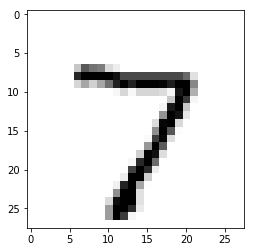

In [3]:
import gzip, binascii, struct, numpy
import matplotlib.pyplot as plt

with gzip.open(test_data_filename) as f:
    # Print the header fields.
    for field in ['magic number', 'image count', 'rows', 'columns']:
        # struct.unpack reads the binary data provided by f.read.
        # The format string '>i' decodes a big-endian integer, which
        # is the encoding of the data.
        print(field, struct.unpack('>i', f.read(4))[0])
    
    # Read the first 28x28 set of pixel values. 
    # Each pixel is one byte, [0, 255], a uint8.
    buf = f.read(28 * 28)
    image = numpy.frombuffer(buf, dtype=numpy.uint8)

%matplotlib inline

# We'll show the image and its pixel value histogram side-by-side.
_, ax1 = plt.subplots(1, 1)

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
ax1.imshow(image.reshape(28, 28), cmap=plt.cm.Greys);

### Let us read the whole data set and store it in 'mnist' variable

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

# N.B. using maybe_download() from above is not necessary, input_data.read_data_sets() can do it all
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

Extracting /tmp/mnist-data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist-data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist-data/t10k-labels-idx1-ubyte.gz


# Define Convolutional network

### First define functions for weights and biases

In [8]:
def weight_variable(shape):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


def bias_variable(shape):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

### Convolutional layer ...

In [9]:
def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

### ... and pooling layer

In [10]:
def max_pool_2x2(x):
  """max_pool_2x2 downsamples a feature map by 2X."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

### Now build the neural network:

In [12]:
def deepnn(x):
  """deepnn builds the graph for a deep net for classifying digits.
  Args:
    x: an input tensor with the dimensions (N_examples, 784), where 784 is the
    number of pixels in a standard MNIST image.
  Returns:
    A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
    equal to the logits of classifying the digit into one of 10 classes (the
    digits 0-9). keep_prob is a scalar placeholder for the probability of
    dropout.
  """
  # Reshape to use within a convolutional neural net.
  # Last dimension is for "features" - there is only one here, since images are
  # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
  x_image = tf.reshape(x, [-1, 28, 28, 1])

  # First convolutional layer - maps one grayscale image to 32 feature maps.
  W_conv1 = weight_variable([5, 5, 1, 32])
  b_conv1 = bias_variable([32])
  h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X.
  h_pool1 = max_pool_2x2(h_conv1)

  # Second convolutional layer -- maps 32 feature maps to 64.
  W_conv2 = weight_variable([5, 5, 32, 64])
  b_conv2 = bias_variable([64])
  h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # Second pooling layer.
  h_pool2 = max_pool_2x2(h_conv2)

  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
  # is down to 7x7x64 feature maps -- maps this to 1024 features.
  W_fc1 = weight_variable([7 * 7 * 64, 1024])
  b_fc1 = bias_variable([1024])

  h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout - controls the complexity of the model, prevents co-adaptation of
  # features.
  keep_prob = tf.placeholder(tf.float32)
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Map the 1024 features to 10 classes, one for each digit
  W_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])

  y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  return y_conv, keep_prob

### Prepare placeholders for (x,y)

In [14]:
 # Create the model
x = tf.placeholder(tf.float32, [None, 784])

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

### Build the graph for the deep net

In [15]:
y_conv, keep_prob = deepnn(x)

### Define some hyperparameters

In [35]:
mnist_batchsize = 50
mnist_steps = 5000
epsilon = 1e-4

### Define cross_entropy, optimizer, accuracy etc

In [36]:
cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(epsilon).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Train the network

In [38]:
import time
import math
from datetime import datetime

check_step = 1000

# start time
start = time.time()

train_duration = 0.0
train_duration_squared = 0.0
check_duration = 0.0
dtcheck = 0.0
tcheck_prev = start

# to store training history
from collections import namedtuple

ParamHeader = ['Timestamp', 'Info', 'Batch_size', 'Num_steps', 'TestAccuracy', 'TotalTime', 'TestTime', 'TrainTime', 'MeanPerBatch', 'StDev']
ParamEntry = namedtuple('ParamEntry', ParamHeader)

param_entries = []
param_entries.append(ParamHeader) 


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(mnist_steps):          
      batch = mnist.train.next_batch(mnist_batchsize)

      if i % check_step == 0 :
        tcheck = time.time()
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}) 
        dtcheck = tcheck - tcheck_prev
        nbatches = check_step if i > 0 else 0
        t1batch = dtcheck/float(nbatches) if nbatches > 0 else 0
        print('step {0:6d}, training accuracy {1:5.3f} ({2:5d} batches trained in {3:6.4f} s, i.e. {4:9.07f} s/batch)'
              .format(i, train_accuracy, nbatches, dtcheck, t1batch))
        tcheck_prev = time.time()
        check_duration += (time.time() - tcheck)
        
      start_train = time.time()     # measure training time per batch
      train_step_ = sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

      duration = time.time() - start_train   # measure training time per batch
      train_duration += duration
      train_duration_squared += duration * duration
    
    start_test = time.time()
    param_accuracy = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
    test_duration = time.time() - start_test
    total_runtime = time.time()

    mn = train_duration / mnist_steps
    vr = train_duration_squared / mnist_steps - mn * mn
    sd = math.sqrt(vr)
    print('\ntest accuracy %g' % param_accuracy)
    print('run in %g s, test: %g s, checks: %g s, train: %g s' % 
         (total_runtime, test_duration, check_duration, train_duration))
    print('mean per batch %g +/- %g s' % (mn, sd))
    param_entries.append(ParamEntry(
                         datetime.now(), "mnist", mnist_batchsize, mnist_steps, param_accuracy, 
                         total_runtime, test_duration, train_duration, mn, sd))


step      0, training accuracy 0.080 (    0 batches trained in 0.1268 s, i.e. 0.0000000 s/batch)
step   1000, training accuracy 0.960 ( 1000 batches trained in 7.9577 s, i.e. 0.0079577 s/batch)
step   2000, training accuracy 0.940 ( 1000 batches trained in 7.8035 s, i.e. 0.0078035 s/batch)
step   3000, training accuracy 0.960 ( 1000 batches trained in 7.8377 s, i.e. 0.0078377 s/batch)
step   4000, training accuracy 1.000 ( 1000 batches trained in 7.8112 s, i.e. 0.0078112 s/batch)

test accuracy 0.9853
run in 1.5291e+09 s, test: 0.325888 s, checks: 0.0294223 s, train: 38.8732 s
mean per batch 0.00777465 +/- 0.000587986 s


### Store training results in .csv file

In [34]:
import tools.storeincsv as incsv

CSV_FILE = "mnist_training.csv"
incsv.store_data_in_csv(CSV_FILE, param_entries)

ImportError: No module named tools.storeincsv